In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import math
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


In [7]:
df = pd.read_csv("data/df_pp.csv")

In [8]:
df

,Data,Grupo,Detentora,Vendor,eNodeB,Cell,TIM_PRB_AVAIL (Unid),TIM_PRB_UTIL_MEAN_DL (%),TIM_PRB_UTIL_MEAN_DL_DEN (Unid),TIM_PRB_UTIL_MEAN_DL_NUM (Unid),TIM_THROU_USER_PDCP_DL (Kbps),TIM_THROU_USER_PDCP_DL_DEN (ms),TIM_THROU_USER_PDCP_DL_NUM (bit),TIM_USERS_RRC_CONN_MEAN_SUM_ALLOP (Unid),TIM_VOLUME_DADOS_DLUL_ALLOP (KB),TIM_VOLUME_DADOS_DL_ALLOP (KB),SET_NUMBER_0,SET_NUMBER_1,SET_NUMBER_2,SET_NUMBER_3
0,2025-09-15 00:00,LMS_UFF_TNE,TIM,HUAWEI,4G-BRBRJ0,4G-BRBRJ0-07-A,50.0,4.544,50.0,227.2,4180.205130,383191.0,1.601817e+09,6.865,226689.593750,207852.999023,0,1,0,0
1,2025-09-15 00:00,LMS_UFF_TNE,TIM,HUAWEI,4G-BRBRJ0,4G-BRBRJ0-07-B,50.0,5.398,50.0,269.9,7406.687408,332539.0,2.463012e+09,6.736,371498.003906,333790.555664,0,1,0,0
2,2025-09-15 00:00,LMS_UFF_TNE,TIM,HUAWEI,4G-BRBRJ0,4G-BRBRJ0-07-C,50.0,4.316,50.0,215.8,1499.223530,428735.0,6.427696e+08,5.408,92756.415039,80417.963867,0,1,0,0
3,2025-09-15 00:00,LMS_UFF_TNE,TIM,HUAWEI,4G-BRBRJ0,4G-BRBRJ0-26-A,100.0,0.935,100.0,93.5,6543.122840,3183.0,2.082676e+07,2.225,7556.021484,4790.798828,0,1,0,0
4,2025-09-15 00:00,LMS_UFF_TNE,TIM,HUAWEI,4G-BRBRJ0,4G-BRBRJ0-26-B,100.0,0.892,100.0,89.2,7135.451613,744.0,5.308776e+06,0.199,832.632812,725.502930,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20167,2025-09-29 23:00,LMS_UFF_TNE,TIM,HUAWEI,4G-OBOBJ0,4G-OBOBJ0-26-B,100.0,3.184,100.0,318.4,39158.936126,25018.0,9.796783e+08,4.355,159533.857422,142852.800781,1,0,0,0
20168,2025-09-29 23:00,LMS_UFF_TNE,TIM,HUAWEI,4G-OBOBJ0,4G-OBOBJ0-26-C,100.0,3.003,100.0,300.3,40296.739137,6191.0,2.494771e+08,1.001,35449.901367,32702.747070,1,0,0,0
20169,2025-09-29 23:00,LMS_UFF_TNE,TIM,HUAWEI,4G-OBOBJ0,4G-OBOBJ0-26-I,50.0,6.616,50.0,330.8,24507.526096,74437.0,1.824267e+09,4.844,348986.671875,324642.206055,1,0,0,0
20170,2025-09-29 23:00,LMS_UFF_TNE,TIM,HUAWEI,4G-OBOBJ0,4G-OBOBJ0-26-J,50.0,6.900,50.0,345.0,43202.575719,67321.0,2.908441e+09,17.281,537333.431641,477212.602539,1,0,0,0


### Clustering 

In [ ]:
resultados = []

dbscan = DBSCAN(eps=1, min_samples=5)
labels = dbscan.fit_predict(df.select_dtypes(include="number"))
df["cluster_dbscan"] = labels

# Calcular silhueta (se possível)
if "cluster_dbscan" not in df.columns:
    print("O DataFrame não possui coluna 'cluster_dbscan'.")
    sil_score = None
else:
    mask = df['cluster_dbscan'] != -1
    df_sem_ruido = df[mask]

    if df_sem_ruido.empty:
        sil_score = None
    else:
        num_cols = df_sem_ruido.select_dtypes(include="number").columns
        if 'cluster_dbscan' in num_cols:
            num_cols = num_cols.drop('cluster_dbscan')

        if len(set(df_sem_ruido['cluster_dbscan'])) > 1:
            sil_score = silhouette_score(df_sem_ruido[num_cols], df_sem_ruido['cluster_dbscan'])
        else:
            sil_score = None

# Adicionar a silhueta no df inteiro
df["silhueta"] = sil_score

# Guardar resultado em memória
resultados.append({"df": "principal", "silhueta": sil_score})

# Mostrar resultados
for r in resultados:
    print(f"{r['df']}: Silhueta = {r['silhueta']}")

# Mostrar quantos clusters foram criados
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"🔹 DBSCAN encontrou {n_clusters} clusters (excluindo ruído).")


principal: Silhueta = -0.6133793657968823


In [ ]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"🔹 DBSCAN encontrou {n_clusters} clusters.")

🔹 DBSCAN encontrou 34 clusters (excluindo ruído).


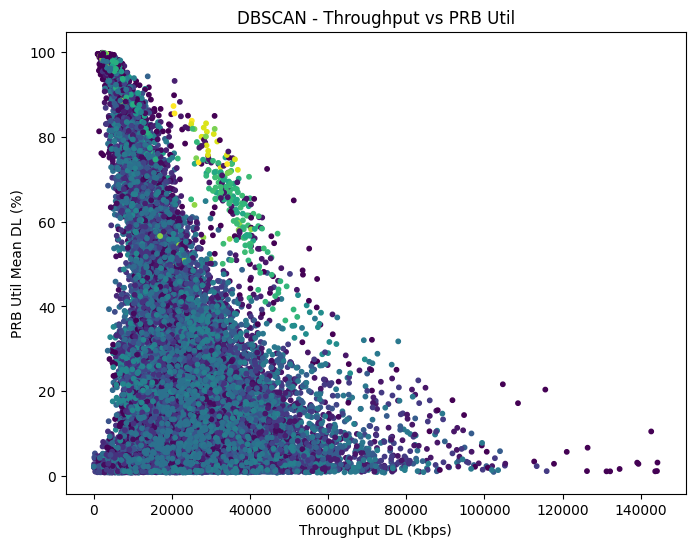

In [12]:
# Verifica se as colunas necessárias existem
cols = ['TIM_THROU_USER_PDCP_DL (Kbps)', 'TIM_PRB_UTIL_MEAN_DL (%)', 'cluster_dbscan']
if not all(col in df.columns for col in cols):
    print("⚠ O DataFrame não possui as colunas necessárias para o gráfico.")
else:
    # Plotar gráfico
    plt.figure(figsize=(8, 6))
    plt.scatter(
        df['TIM_THROU_USER_PDCP_DL (Kbps)'],
        df['TIM_PRB_UTIL_MEAN_DL (%)'],
        c=df['cluster_dbscan'],
        cmap='viridis',
        s=10
    )

    plt.title('DBSCAN - Throughput vs PRB Util')
    plt.xlabel('Throughput DL (Kbps)')
    plt.ylabel('PRB Util Mean DL (%)')

    # Exibir o gráfico na tela (sem salvar)
    plt.show()